###LIME fidelity Calculation

Here's a simplified example to illustrate the process:

1. **Original Instance**: Suppose the instance to explain is \(\mathbf{x} = (x_1, x_2, \ldots, x_n)\).

2. **Generate Perturbations**: Create a set of \(k\) perturbed samples \(\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \ldots, \mathbf{x}^{(k)}\) around \(\mathbf{x}\).

3. **Original Model Predictions**: Get predictions for these perturbed samples from the complex model: \(f(\mathbf{x}^{(1)}), f(\mathbf{x}^{(2)}), \ldots, f(\mathbf{x}^{(k)})\).

4. **Train Surrogate Model**: Fit a surrogate model \(g\) using the perturbed samples \(\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \ldots, \mathbf{x}^{(k)}\) and their corresponding predictions from the complex model.

5. **Surrogate Model Predictions**: Predict the outputs for the perturbed samples using the surrogate model: \(g(\mathbf{x}^{(1)}), g(\mathbf{x}^{(2)}), \ldots, g(\mathbf{x}^{(k)})\).

6. **Calculate Fidelity**: Compute the fidelity metric. For instance, using R-squared:
   \[
   R^2 = 1 - \frac{\sum_{i=1}^k (f(\mathbf{x}^{(i)}) - g(\mathbf{x}^{(i)}))^2}{\sum_{i=1}^k (f(\mathbf{x}^{(i)}) - \bar{f})^2}
   \]
   where \(\bar{f}\) is the mean of the original model's predictions for the perturbed samples:
   \[
   \bar{f} = \frac{1}{k} \sum_{i=1}^k f(\mathbf{x}^{(i)})
   \]

A high \(R^2\) value close to 1 indicates high fidelity, meaning the surrogate model's predictions closely match those of the complex model within the local region around the instance being explained.

By following these steps, you can quantitatively assess the fidelity of the LIME explanation, ensuring that the surrogate model provides a reliable approximation of the complex model's behavior in the local neighborhood of the instance.


**LIME Fidelity** can also be calculated by calling the "score" from LIME function, i.e. **explanation.score**
-explanation.intercept is a float, 
-explanation.exp is a sorted list of tuples, where each tuple (x,y) corresponds to the feature id (x) and the local weight (y). The list is sorted by decreasing absolute value of y. 
-explanation.score is the R^2 value of the returned explanation.
-explanation.local_pred is the prediction of the explanation model on the original instance

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE 

from collections import Counter
from sklearn.datasets import make_classification
from interpret.blackbox import LimeTabular
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt
from lime_stability.stability import LimeTabularExplainerOvr

In [2]:
all_data = pd.read_csv(r'/Users/ihteshamshah/Desktop/Postdoc/Dataset/NKR_IKNL_breast_syntheticdata.csv')
DataSet= all_data[['leeft' ,'gesl', 'tumsoort', 'diag_basis', 'topo', 'topo_sublok', 'later', 'morf', 'ct', 'cn', 'cm', 'cstadium', 'er_stat', 'pr_stat', 'her2_stat', 'dcis_comp', 'multifoc','chemo', 'target', 'horm', 'rt', 'meta_chir']]
DataSet.columns = ['Age_at_incidence_date', 'Sex', 
                'Tumor_type', 'Basis_for_diagnosis', 'Topography_excluding', 
                'Topography_including', 'Lateralization', 'Morphology', 'cT_TNM', 'cN_TNM', 'cm_TNM',
                'Stage_based_on_cTNM', 'Er_status', 'Pr_status', 'HER2_state', 'DCIS_component',
                  'Tumor_multifocality', 'chemo','target','hormonal','radio','surgery']
DataSet.dropna(inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
data = pd.get_dummies(DataSet, drop_first = True) #drop_first= ture prevents from dummy trap and it delete the first column.
data.reset_index(drop=True, inplace=True)
DATA=data #for later use when dealing with imbalance dataset (weight and smote methods)


In [5]:
ds=data.iloc[[0, 1000,1100,20000]]
pd.set_option('display.max_columns', None)
ds.head()

,Age_at_incidence_date,Sex,Tumor_type,Basis_for_diagnosis,Lateralization,Morphology,cm_TNM,Er_status,Pr_status,HER2_state,DCIS_component,Tumor_multifocality,chemo,target,hormonal,radio,surgery,Topography_including_C501,Topography_including_C502,Topography_including_C503,Topography_including_C504,Topography_including_C505,Topography_including_C506,Topography_including_C508,Topography_including_C509,cT_TNM_1,cT_TNM_1A,cT_TNM_1B,cT_TNM_1C,cT_TNM_1M,cT_TNM_2,cT_TNM_3,cT_TNM_4A,cT_TNM_4B,cT_TNM_4C,cT_TNM_4D,cT_TNM_IS,cN_TNM_1,cN_TNM_2A,cN_TNM_2B,cN_TNM_3A,cN_TNM_3B,cN_TNM_3C,Stage_based_on_cTNM_1A,Stage_based_on_cTNM_2A,Stage_based_on_cTNM_2B,Stage_based_on_cTNM_3A,Stage_based_on_cTNM_3B,Stage_based_on_cTNM_3C,Stage_based_on_cTNM_4,Stage_based_on_cTNM_M
0,93,2,501300,7,1.0,8500,0.0,1.0,0.0,3.0,0.0,0.0,0,4,0,0,0,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1000,67,2,501300,7,1.0,8500,0.0,1.0,1.0,0.0,0.0,0.0,1,2,2,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1100,69,2,501300,7,2.0,8500,0.0,1.0,1.0,1.0,1.0,0.0,0,3,2,0,0,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
20000,69,2,501300,7,2.0,8500,0.0,1.0,1.0,3.0,1.0,0.0,1,0,0,2,0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [464]:
X = data.loc[:, ~data.columns.isin(['chemo','target','hormonal','radio','surgery'])]
Y = data[['chemo','target','hormonal','radio','surgery']]

In [465]:
classes_names = {'chemo':['chemo_0','chemo_presurgical only','chemo_post-surgical only','chemo_pre and post surgical','chemo_Yes, no surgery'],
        'target':['target_0','target_presurgical only','target_post-surgical only','target_pre and post surgical','target_Yes, no surgery'],
        'hormonal':['hormonal_0','hormonal_presurgical only','hormonal_post-surgical only','hormonal_pre and post surgical','hormonal_Yes, no surgery'],
        'radio':['radio_0','radio_presurgical only','radio_post-surgical only','radio_Yes, no surgery'],
        'surgery':['No_surgery','surgery']}

#classes_names = {'chemo':['chemo_0','chemo_1','chemo_2','chemo_3','chemo_4'],
#        'target':['target_0','target_1','target_2','target_3','target_4'],
#        'hormonal':['hormonal_0','hormonal_1','hormonal_2','hormonal_3','hormonal_4'],
#        'radio':['radio_0','radio_1','radio_2','radio_4'],
#        'surgery':['surgery', 'No_surgery']}


y=Y['surgery']
smote = SMOTE(random_state=42)

X_class_resampled, y_class_resampled = smote.fit_resample(X , y)

X_class_resampled.replace({False: 0, True: 1}, inplace=True)
y_class_resampled.replace({False:0, True:1}, inplace= True)


print('Origianl dataset shape:', Counter(y))
print('Resampple dataset shape:', Counter(y_class_resampled))

x_train,x_test,y_train,y_test=train_test_split(X_class_resampled,y_class_resampled,test_size=0.2)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#X_res, y_res = sm.fit_resample(x_train, y_train)

#Randomforest Classifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

Origianl dataset shape: Counter({0: 35853, 1: 3657})
Resampple dataset shape: Counter({0: 35853, 1: 35853})


In [466]:
# Choose a sample to explain
j = 2
sample = x_test.iloc[[j], :]

Predicted_class= rf.predict(sample)[0]
print(f'Actual class: {y_test[j]}')
print(f'Predicted class: {rf.predict(sample)[0]}')
print(f'Prediction for 1st sample in X_test: {rf.predict_proba(x_test.iloc[[j], :])[0]}')

Actual class: 0
Predicted class: 0
Prediction for 1st sample in X_test: [0.78667039 0.21332961]


# LIME and SHAP fidelity

In [467]:

#LIME explainer single instance for same sample used for shap
# Choose a sample to explain
#discretize_continuous=True, verbose=True show the following outcomes.
#intercept , Prediction_local= Lime prediction, Right= Actual model's prediction.




Lime_fidelity=[]
Shap_fidelity=[]

#Lime Explainer
LIME_explainer = LimeTabularExplainer(x_train.values, 
                             feature_names=x_train.columns, 
                             class_names=classes_names[y_test.name], 
                             discretize_continuous=True, verbose=True)
#Shap Explainer 

# Define the number of samples to summarize the background data
K = 100  # Choose an appropriate value for K

# Summarize the background data using shap.sample()
background_sample = shap.sample(x_train, K)

# Use the summarized background sample in your SHAP model
#Shap_explainer = shap.KernelExplainer(model=rf.predict_proba, data=background_sample, link = 'logit')
Shap_explainer = shap.KernelExplainer(model=rf.predict_proba, data=background_sample)



In [468]:



# Explanation over 20 single points 

#j=np.random.randint(1000, size=(20)) #randomly pick 20 instances from data (in the range of 1000 intances)


for i in range(15):
    data_row = x_test.iloc[[i], :] #single instance from the test dataset
    sample =data_row.values.reshape(1, -1) #reshape the sample and pickup the value only (making it suitble for lime function)
    #print(f'Actual class: {y_test[j]}')
    #print(f'Predicted class: {rf.predict(sample)[0]}')

    # Explain the prediction for the chosen sample
    LIME_explanation = LIME_explainer.explain_instance(sample[0], rf.predict_proba, num_features=46, top_labels=20)
    #AA= np.array(exp.local_pred, dtype==int)
    Lime_fidelity.append(LIME_explanation.score)
    
    
    #Data_row = x_test.iloc[[3], :]
    Predicted_class= rf.predict(data_row)[0]


    shap_values_single_instance = Shap_explainer.shap_values(data_row, nsamples=100, l1_reg="num_features(28)")
    shap_fedilty= ((rf.predict_proba(data_row)[0][Predicted_class]) /
                (Shap_explainer.fnull[Predicted_class] + np.sum(np.abs(shap_values_single_instance[Predicted_class]))))
    Shap_fidelity.append(shap_fedilty)





Intercept 0.771641212283824
Prediction_local [0.89137492]
Right: 0.02
Intercept 0.22835878771617577
Prediction_local [0.10862508]
Right: 0.98


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.278780525576086
Prediction_local [-0.00226457]
Right: 0.0
Intercept 0.7212194744239142
Prediction_local [1.00226457]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.8418388318605872
Prediction_local [0.88145117]
Right: 0.21332961482961482
Intercept 0.1581611681394131
Prediction_local [0.11854883]
Right: 0.7866703851703853


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14775935899184806
Prediction_local [0.04384155]
Right: 0.0
Intercept 0.8522406410081517
Prediction_local [0.95615845]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.21680544054592696
Prediction_local [0.04798523]
Right: 0.04
Intercept 0.7831945594540735
Prediction_local [0.95201477]
Right: 0.96


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.2521386256639231
Prediction_local [0.00072976]
Right: 0.0
Intercept 0.7478613743360767
Prediction_local [0.99927024]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.8922494400710711
Prediction_local [0.93766009]
Right: 0.42
Intercept 0.10775055992892872
Prediction_local [0.06233991]
Right: 0.58


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.8395631028230925
Prediction_local [0.94063517]
Right: 0.0075
Intercept 0.16043689717690723
Prediction_local [0.05936483]
Right: 0.9925


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.853232175468553
Prediction_local [0.87864357]
Right: 0.08
Intercept 0.14676782453144693
Prediction_local [0.12135643]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11210540317865755
Prediction_local [0.11272905]
Right: 0.01
Intercept 0.8878945968213424
Prediction_local [0.88727095]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.29099618621329637
Prediction_local [-0.03682716]
Right: 0.02
Intercept 0.7090038137867039
Prediction_local [1.03682716]
Right: 0.98


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.8978939348413137
Prediction_local [0.92417449]
Right: 0.0
Intercept 0.10210606515868634
Prediction_local [0.07582551]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.7847355859975707
Prediction_local [0.90542883]
Right: 0.0025
Intercept 0.21526441400242935
Prediction_local [0.09457117]
Right: 0.9974999999999998


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.22000841730867543
Prediction_local [0.00276604]
Right: 0.04
Intercept 0.7799915826913245
Prediction_local [0.99723396]
Right: 0.96


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.29422102858724364
Prediction_local [-0.04914991]
Right: 0.0
Intercept 0.7057789714127563
Prediction_local [1.04914991]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

In [469]:
#Lime_fidelity

In [470]:
#Shap_fidelity

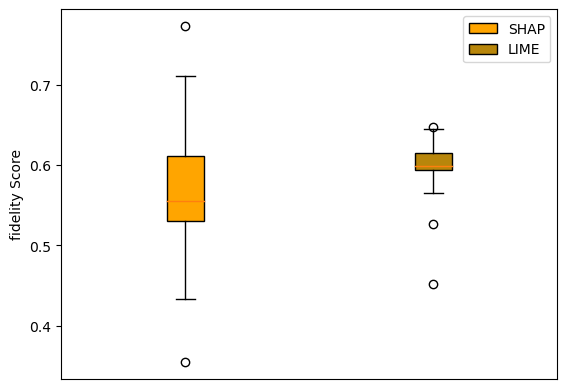

In [471]:
# Fidelity Plot for LIME and SHAP
# Import libraries
import matplotlib.pyplot as plt
#Lime_fidelity = list(np.around(np.array(Lime_fidelity),2)) 

plot_data = [Shap_fidelity, Lime_fidelity]

labels = ['SHAP', 'LIME']
colors = ['orange', 'darkgoldenrod']

fig, ax = plt.subplots()
ax.set_ylabel('fidelity Score')

bplot = ax.boxplot(plot_data,
                   patch_artist=True)  # fill with color

# fill with colors and add legend labels
for patch, color, label in zip(bplot['boxes'], colors, labels):
    patch.set_facecolor(color)
    patch.set_label(label)
    
ax.legend()
ax.get_xaxis().set_visible(False)

plt.show()

In [220]:
data_row = x_test.iloc[[666], :]

In [221]:
explanation.score

0.35931391526609535

In [222]:
explanation.local_pred

array([0.16845441])

In [223]:
#explanation.local_pred[0]/max(rf.predict_proba(x_test.iloc[[j], :])[0])

In [224]:
explanation.intercept

{0: 0.19701945260199163,
 2: -0.06661790183452476,
 1: 0.21013738717200683,
 3: 0.0028958937440794474,
 4: 0.6565651683164472}

In [204]:
np.sum(np.abs(shap_values_single_instance[Predicted_class]))

1.458928711036063

In [205]:
Shap_explainer.fnull[Predicted_class]

0.21250000000000005

In [206]:
rf.predict_proba(Data_row)[0][Predicted_class]

0.01

In [207]:
max(rf.predict_proba(sample)[0])

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


0.99

# Stability of LIME and SHAP 

based on paper in the link https://arxiv.org/pdf/2001.11757 


###Pseudocode

Explainer(lime and shap) 

for loop --> new data instance
        newdata instance
        predicted calss
        
        for loop --> explanation generated multiple times for same instance
            -explanation for single instance 
            -store values of top five positve features (supportive features for predicted label)
            -append top five positve features in an array
        calculate vsi,
        store vsi values in VSI array


In [472]:
import itertools

def concordance(pair):
    """Function to calculate the concordance of a pair of explanations."""
    g1, g2 = pair
    return len(set(g1).intersection(set(g2)))

def calculate_vsi(explanations):
    """Calculate the Variance Score Index (VSI) from LIME explanations."""
    m = len(explanations)
    n = 0
    p = len(explanations[0])  # Assuming all explanations have the same length

    # Generate all pairs of explanations
    pairs = list(itertools.combinations(explanations, 2))

    # Calculate the sum of concordances
    for pair in pairs:
        n += concordance(pair) / p

    # Calculate the total number of pairs
    total_pairs = len(pairs)

    # Calculate VSI
    vsi = n / total_pairs
    return vsi


In [473]:
Lime_VSI=[]

Instances =np.random.randint(100, size=(10)) #randomly pick 10 instances from data (in the range of 100 intances)

for instance in Instances:
    data_row = x_test.iloc[[instance], :] #single instance from the test dataset
    sample =data_row.values.reshape(1, -1)

    Predicted_class= rf.predict(sample)[0]
    Actual_class= y_test[instance]


    Lime_Explanations= []


    for _ in range(3): #generate 3 time explaination of same instance and compare them

        ##############. Lime  #################
        LIME_explanation = LIME_explainer.explain_instance(sample[0], rf.predict_proba, num_features=46, top_labels=5)
        lime_values_of_Prid_cls= LIME_explanation.local_exp[Predicted_class]
        column_names=x_train.columns
        positive_list = [(x, y) for x, y in lime_values_of_Prid_cls if y > 0]
        # Separate the x and y values
        x_values = [x for x, y in positive_list]
        x_names = [column_names[t] for t in x_values]
        y_values = [y for x, y in positive_list]

        # Combine x_names and y_values into a list of tuples and sort by y_values
        sorted_list = sorted(zip(x_names, y_values), key=lambda pair: pair[1], reverse=True)

        # Unzip the sorted list
        x_names_sorted, y_values_sorted = zip(*sorted_list)
        top_five_features = x_names_sorted[:5]
        Lime_Explanations.append(top_five_features)

    Lime_vsi = calculate_vsi(Lime_Explanations)
    Lime_VSI.append(Lime_vsi)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.22228204965786985
Prediction_local [0.03346492]
Right: 0.0
Intercept 0.7777179503421309
Prediction_local [0.96653508]
Right: 1.0
Intercept 0.21306709185246223
Prediction_local [0.03963685]
Right: 0.0
Intercept 0.7869329081475379
Prediction_local [0.96036315]
Right: 1.0
Intercept 0.14223994905189496
Prediction_local [0.03681339]
Right: 0.0
Intercept 0.8577600509481049
Prediction_local [0.96318661]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.8485736568847
Prediction_local [0.94301347]
Right: 0.42
Intercept 0.1514263431153003
Prediction_local [0.05698653]
Right: 0.58
Intercept 0.8307092457460018
Prediction_local [0.94108062]
Right: 0.42
Intercept 0.16929075425399792
Prediction_local [0.05891938]
Right: 0.58
Intercept 0.8829589443477773
Prediction_local [0.94646284]
Right: 0.42
Intercept 0.11704105565222214
Prediction_local [0.05353716]
Right: 0.58


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.898990513243122
Prediction_local [0.84144959]
Right: 0.15
Intercept 0.10100948675687806
Prediction_local [0.15855041]
Right: 0.85
Intercept 0.8709360279145798
Prediction_local [0.85112944]
Right: 0.15
Intercept 0.12906397208542048
Prediction_local [0.14887056]
Right: 0.85
Intercept 0.8964310979824496
Prediction_local [0.84067951]
Right: 0.15
Intercept 0.10356890201755083
Prediction_local [0.15932049]
Right: 0.85


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.872675762015527
Prediction_local [0.8562246]
Right: 0.21749999999999997
Intercept 0.12732423798447265
Prediction_local [0.1437754]
Right: 0.7825
Intercept 0.9124839327240162
Prediction_local [0.84309142]
Right: 0.21749999999999997
Intercept 0.0875160672759845
Prediction_local [0.15690858]
Right: 0.7825
Intercept 0.9393415749447674
Prediction_local [0.83189043]
Right: 0.21749999999999997
Intercept 0.06065842505523263
Prediction_local [0.16810957]
Right: 0.7825


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.8871239590664246
Prediction_local [0.84580372]
Right: 0.06
Intercept 0.11287604093357559
Prediction_local [0.15419628]
Right: 0.94
Intercept 0.88118218850593
Prediction_local [0.85062186]
Right: 0.06
Intercept 0.11881781149406993
Prediction_local [0.14937814]
Right: 0.94
Intercept 0.8625101455883
Prediction_local [0.85157685]
Right: 0.06
Intercept 0.1374898544117002
Prediction_local [0.14842315]
Right: 0.94


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.8674242744305027
Prediction_local [0.93440879]
Right: 0.17
Intercept 0.13257572556949707
Prediction_local [0.06559121]
Right: 0.83
Intercept 0.8995003294022896
Prediction_local [0.93052187]
Right: 0.17
Intercept 0.10049967059770999
Prediction_local [0.06947813]
Right: 0.83
Intercept 0.8707882760637136
Prediction_local [0.93889025]
Right: 0.17
Intercept 0.12921172393628666
Prediction_local [0.06110975]
Right: 0.83


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.821606577336754
Prediction_local [0.94319988]
Right: 0.23
Intercept 0.1783934226632457
Prediction_local [0.05680012]
Right: 0.77
Intercept 0.8401277621634669
Prediction_local [0.95546848]
Right: 0.23
Intercept 0.1598722378365331
Prediction_local [0.04453152]
Right: 0.77
Intercept 0.813861667261415
Prediction_local [0.92815352]
Right: 0.23
Intercept 0.18613833273858496
Prediction_local [0.07184648]
Right: 0.77


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.8883449362886778
Prediction_local [0.89803879]
Right: 0.08
Intercept 0.11165506371132197
Prediction_local [0.10196121]
Right: 0.92
Intercept 0.8691480491197748
Prediction_local [0.90068871]
Right: 0.08
Intercept 0.13085195088022528
Prediction_local [0.09931129]
Right: 0.92
Intercept 0.8785572648080786
Prediction_local [0.88978592]
Right: 0.08
Intercept 0.12144273519192134
Prediction_local [0.11021408]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9010474294647789
Prediction_local [0.84560108]
Right: 0.07
Intercept 0.09895257053522119
Prediction_local [0.15439892]
Right: 0.93
Intercept 0.8584263786329123
Prediction_local [0.84258211]
Right: 0.07
Intercept 0.14157362136708734
Prediction_local [0.15741789]
Right: 0.93
Intercept 0.9156453253082156
Prediction_local [0.84167273]
Right: 0.07
Intercept 0.08435467469178468
Prediction_local [0.15832727]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.26385398513454894
Prediction_local [-0.01270008]
Right: 0.02
Intercept 0.7361460148654511
Prediction_local [1.01270008]
Right: 0.98
Intercept 0.20559694955245492
Prediction_local [-0.0012705]
Right: 0.02
Intercept 0.7944030504475451
Prediction_local [1.0012705]
Right: 0.98
Intercept 0.20392162978663436
Prediction_local [-0.01603929]
Right: 0.02
Intercept 0.7960783702133654
Prediction_local [1.01603929]
Right: 0.98


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [478]:

Shap_VSI=[]
#Instances =np.random.randint(100, size=(10)) #randomly pick 10 instances from data (in the range of 100 intances)

for instance in Instances:
    data_row = x_test.iloc[[instance], :] #single instance from the test dataset
    sample =data_row.values.reshape(1, -1)

    Predicted_class= rf.predict(sample)[0]
    Actual_class= y_test[instance]

    Shap_Explanations= []

    for _ in range(3): #generate 3 time explaination of same instance and compare them

        #############. Shap  #####################
        shap_values_single_instance = Shap_explainer.shap_values(data_row, nsamples=100, l1_reg="num_features(46)")

        # Provided SHAP values and column names
        shap_valuesss = shap_values_single_instance[Predicted_class][0]
        column_namesss = x_train.columns
        # Flatten shap_values array
        #shap_values = shap_values.flatten()

        # Filter positive SHAP values
        positive_shap_indices = np.where(shap_valuesss > 0)[0]
        positive_shap_values = shap_valuesss[positive_shap_indices]
        positive_shap_columns = np.array(column_namesss)[positive_shap_indices]

        # Combine and sort by SHAP values
        positive_shap_list = list(zip(positive_shap_columns, positive_shap_values))
        positive_shap_list.sort(key=lambda x: x[1], reverse=True)

        # Select top 20
        top_5_shap = positive_shap_list[:5]
        #print('top_5_shap=', top_5_shap)
        # Unzip to get column names and values
        top_5_columns, top_5_values = zip(*top_5_shap)
        #print('top_5_columns)=', top_5_columns)
        Shap_Explanations.append(top_5_columns)

    Shap_vsi= calculate_vsi(Shap_Explanations)
    Shap_VSI.append(Shap_vsi)




X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

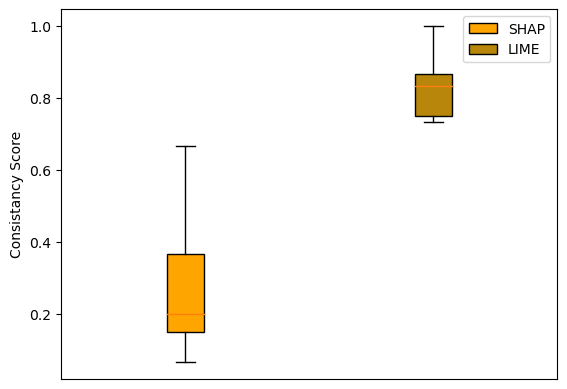

In [479]:
# Fidelity Plot for LIME and SHAP
# Import libraries
import matplotlib.pyplot as plt
#Lime_fidelity = list(np.around(np.array(Lime_fidelity),2)) 

plot_data = [Shap_VSI, Lime_VSI]

labels = ['SHAP', 'LIME']
colors = ['orange', 'darkgoldenrod']

fig, ax = plt.subplots()
ax.set_ylabel('Consistancy Score')

bplot = ax.boxplot(plot_data,
                   patch_artist=True)  # fill with color

# fill with colors and add legend labels
for patch, color, label in zip(bplot['boxes'], colors, labels):
    patch.set_facecolor(color)
    patch.set_label(label)
    
ax.legend()
ax.get_xaxis().set_visible(False)

plt.show()

In [476]:
plot_data

[[0.8000000000000002,
  0.4000000000000001,
  0.6666666666666666,
  0.4666666666666666,
  0.3333333333333333,
  0.6666666666666666,
  0.8666666666666667,
  0.6666666666666666,
  0.7333333333333334,
  0.7333333333333334],
 [1.0,
  0.7333333333333334,
  0.8666666666666667,
  0.8666666666666667,
  0.8000000000000002,
  0.7333333333333334,
  0.7333333333333334,
  0.8000000000000002,
  0.8666666666666667,
  1.0]]

#### Combined Code 


In [457]:
Lime_VSI=[]
Shap_VSI=[]
Instances =np.random.randint(100, size=(10)) #randomly pick 10 instances from data (in the range of 100 intances)

for instance in Instances:
    data_row = x_test.iloc[[instance], :] #single instance from the test dataset
    sample =data_row.values.reshape(1, -1)

    Predicted_class= rf.predict(sample)[0]
    Actual_class= y_test[instance]
   


    Lime_Explanations= []
    Shap_Explanations= []
    
    for _ in range(5): #generate 3 time explaination of same instance and compare them
        
        ##############. Lime  #################
        LIME_explanation = LIME_explainer.explain_instance(sample[0], rf.predict_proba, num_features=46, top_labels=5)
        lime_values_of_Prid_cls= LIME_explanation.local_exp[Predicted_class]
        column_names=x_train.columns
        positive_list = [(x, y) for x, y in lime_values_of_Prid_cls if y > 0]
        # Separate the x and y values
        x_values = [x for x, y in positive_list]
        x_names = [column_names[t] for t in x_values]
        y_values = [y for x, y in positive_list]

        # Combine x_names and y_values into a list of tuples and sort by y_values
        sorted_list = sorted(zip(x_names, y_values), key=lambda pair: pair[1], reverse=True)

        # Unzip the sorted list
        x_names_sorted, y_values_sorted = zip(*sorted_list)
        top_five_features = x_names_sorted[:5]
        Lime_Explanations.append(top_five_features)
        
        
        #############. Shap  #####################
        shap_values_single_instance = Shap_explainer.shap_values(data_row, nsamples=100, l1_reg="num_features(46)")

        # Provided SHAP values and column names
        shap_valuesss = shap_values_single_instance[Predicted_class][0]
        column_namesss = x_train.columns
        # Flatten shap_values array
        #shap_values = shap_values.flatten()

        # Filter positive SHAP values
        positive_shap_indices = np.where(shap_valuesss > 0)[0]
        positive_shap_values = shap_valuesss[positive_shap_indices]
        positive_shap_columns = np.array(column_namesss)[positive_shap_indices]

        # Combine and sort by SHAP values
        positive_shap_list = list(zip(positive_shap_columns, positive_shap_values))
        positive_shap_list.sort(key=lambda x: x[1], reverse=False)

        # Select top 20
        top_5_shap = positive_shap_list[:5]

        # Unzip to get column names and values
        top_5_columns, top_5_values = zip(*top_5_shap)
        Shap_Explanations.append(top_5_columns)

    Lime_vsi = calculate_vsi(Lime_Explanations)
    Lime_VSI.append(Lime_vsi)
    
    Shap_vsi= calculate_vsi(Shap_Explanations)
    Shap_VSI.append(Shap_vsi)

print("Lime Variable Stability Index (VSI):", Lime_VSI)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.12345565791863634
Prediction_local [0.01574062]
Right: 0.0
Intercept 0.4367987311389771
Prediction_local [0.33138348]
Right: 0.0
Intercept -0.15962329911900136
Prediction_local [0.30382913]
Right: 0.0
Intercept 0.584839117858553
Prediction_local [0.16356428]
Right: 0.0
Intercept 0.014529792202836317
Prediction_local [0.18548249]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.12491198314488602
Prediction_local [0.01155658]
Right: 0.0
Intercept 0.35811103314233056
Prediction_local [0.33089194]
Right: 0.0
Intercept -0.11217195213271502
Prediction_local [0.29428393]
Right: 0.0
Intercept 0.6141671243561317
Prediction_local [0.16547805]
Right: 0.0
Intercept 0.014981811489365976
Prediction_local [0.1977895]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.16910935367933755
Prediction_local [0.0137375]
Right: 0.0
Intercept 0.3458885841191221
Prediction_local [0.33425963]
Right: 0.0
Intercept -0.11439384005539838
Prediction_local [0.2993251]
Right: 0.0
Intercept 0.5766486930847744
Prediction_local [0.15904078]
Right: 0.0
Intercept 0.022747209172163135
Prediction_local [0.19363699]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.170025142543342
Prediction_local [0.00553176]
Right: 0.0
Intercept 0.3225248783702816
Prediction_local [0.32835194]
Right: 0.0
Intercept -0.0896664988676995
Prediction_local [0.30464686]
Right: 0.0
Intercept 0.5889222487097758
Prediction_local [0.16785202]
Right: 0.0
Intercept 0.008194229244300827
Prediction_local [0.19361743]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14288347402510396
Prediction_local [0.01199723]
Right: 0.0
Intercept 0.3582632511775779
Prediction_local [0.32978067]
Right: 0.0
Intercept -0.16149683083284055
Prediction_local [0.30664321]
Right: 0.0
Intercept 0.594342020399432
Prediction_local [0.16332905]
Right: 0.0
Intercept 0.06600808523072489
Prediction_local [0.18824985]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.06749203854830674
Prediction_local [0.11013807]
Right: 0.02
Intercept 0.6161221966204602
Prediction_local [0.10824929]
Right: 0.08
Intercept -0.08186320863892249
Prediction_local [0.30454126]
Right: 0.1
Intercept 0.25227544455164064
Prediction_local [0.40299918]
Right: 0.11
Intercept 0.14597352891851556
Prediction_local [0.0740722]
Right: 0.69


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10727036638501693
Prediction_local [0.10967585]
Right: 0.02
Intercept 0.6932486011195231
Prediction_local [0.10117178]
Right: 0.08
Intercept -0.1209471499077081
Prediction_local [0.30512981]
Right: 0.1
Intercept 0.22849710469797752
Prediction_local [0.40731634]
Right: 0.11
Intercept 0.09193107770519052
Prediction_local [0.07670622]
Right: 0.69


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.16355662278451322
Prediction_local [0.10730776]
Right: 0.02
Intercept 0.6244468436647068
Prediction_local [0.11102341]
Right: 0.08
Intercept -0.10458427478913224
Prediction_local [0.30334426]
Right: 0.1
Intercept 0.220922772233197
Prediction_local [0.40658404]
Right: 0.11
Intercept 0.09565803610671524
Prediction_local [0.07174053]
Right: 0.69


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1280083347192152
Prediction_local [0.10054822]
Right: 0.02
Intercept 0.6368859529628472
Prediction_local [0.09676608]
Right: 0.08
Intercept -0.1423751261757507
Prediction_local [0.31523136]
Right: 0.1
Intercept 0.2968564922920266
Prediction_local [0.40961136]
Right: 0.11
Intercept 0.08062434620166259
Prediction_local [0.07784299]
Right: 0.69


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11509783226013046
Prediction_local [0.1106423]
Right: 0.02
Intercept 0.6822641324094633
Prediction_local [0.10336114]
Right: 0.08
Intercept -0.123767376582049
Prediction_local [0.30408111]
Right: 0.1
Intercept 0.24980818672184749
Prediction_local [0.40801101]
Right: 0.11
Intercept 0.07659722519060821
Prediction_local [0.07390445]
Right: 0.69


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.07227528379576595
Prediction_local [0.17639627]
Right: 0.0
Intercept 0.6588887810938256
Prediction_local [0.10679856]
Right: 0.0
Intercept 0.1441875833534299
Prediction_local [0.01658888]
Right: 0.1738498015142751
Intercept 0.34559664168463
Prediction_local [0.37387215]
Right: 0.19532754599201957
Intercept -0.07639772233612002
Prediction_local [0.32634414]
Right: 0.6308226524937052


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.008193744641256329
Prediction_local [0.17825144]
Right: 0.0
Intercept 0.6339936675461746
Prediction_local [0.11081125]
Right: 0.0
Intercept 0.14984684380148472
Prediction_local [0.01921992]
Right: 0.1738498015142751
Intercept 0.31698326146947153
Prediction_local [0.36853663]
Right: 0.19532754599201957
Intercept -0.10901751745838623
Prediction_local [0.32318076]
Right: 0.6308226524937052


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.020953654039743475
Prediction_local [0.17239423]
Right: 0.0
Intercept 0.683349640610217
Prediction_local [0.09930523]
Right: 0.0
Intercept 0.13008397423245222
Prediction_local [0.02066431]
Right: 0.1738498015142751
Intercept 0.27049700707438007
Prediction_local [0.37164604]
Right: 0.19532754599201957
Intercept -0.10488427595679273
Prediction_local [0.33599019]
Right: 0.6308226524937052


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.010794183953007047
Prediction_local [0.18082838]
Right: 0.0
Intercept 0.6475923882433469
Prediction_local [0.10932023]
Right: 0.0
Intercept 0.15427937138379433
Prediction_local [0.01666201]
Right: 0.1738498015142751
Intercept 0.34444862477813126
Prediction_local [0.36516617]
Right: 0.19532754599201957
Intercept -0.15711456835827847
Prediction_local [0.3280232]
Right: 0.6308226524937052


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.05069848762905657
Prediction_local [0.17496931]
Right: 0.0
Intercept 0.7041792061294947
Prediction_local [0.1081725]
Right: 0.0
Intercept 0.1328457831098593
Prediction_local [0.01786411]
Right: 0.1738498015142751
Intercept 0.2691922629466008
Prediction_local [0.36973331]
Right: 0.19532754599201957
Intercept -0.15691573981501417
Prediction_local [0.32926076]
Right: 0.6308226524937052


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.18980347774832107
Prediction_local [0.08686661]
Right: 0.01
Intercept 0.6502901211457981
Prediction_local [0.11606858]
Right: 0.03
Intercept -0.1589394479672902
Prediction_local [0.27189172]
Right: 0.26
Intercept 0.2850804384890311
Prediction_local [0.42317785]
Right: 0.3
Intercept 0.033765410584141314
Prediction_local [0.10199524]
Right: 0.4


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13728999317150775
Prediction_local [0.06978029]
Right: 0.01
Intercept 0.6681986933623527
Prediction_local [0.11972265]
Right: 0.03
Intercept -0.0346048921530937
Prediction_local [0.27311735]
Right: 0.26
Intercept 0.1732939947533227
Prediction_local [0.42680816]
Right: 0.3
Intercept 0.0558222108659132
Prediction_local [0.11057155]
Right: 0.4


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.19704905341231008
Prediction_local [0.07275285]
Right: 0.01
Intercept 0.6911637099435809
Prediction_local [0.12659769]
Right: 0.03
Intercept -0.09904305470945818
Prediction_local [0.27893206]
Right: 0.26
Intercept 0.17615855028085237
Prediction_local [0.41399785]
Right: 0.3
Intercept 0.03467174107271561
Prediction_local [0.10771955]
Right: 0.4


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.17922601576363578
Prediction_local [0.08090464]
Right: 0.01
Intercept 0.6790064554908551
Prediction_local [0.11563923]
Right: 0.03
Intercept -0.12396750805000445
Prediction_local [0.27578689]
Right: 0.26
Intercept 0.19872399849582714
Prediction_local [0.42032482]
Right: 0.3
Intercept 0.06701103829968708
Prediction_local [0.10734442]
Right: 0.4


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14219700035881466
Prediction_local [0.07564112]
Right: 0.01
Intercept 0.6234122937555449
Prediction_local [0.10299677]
Right: 0.03
Intercept -0.03709279191791426
Prediction_local [0.29394833]
Right: 0.26
Intercept 0.210943039525883
Prediction_local [0.41978787]
Right: 0.3
Intercept 0.06054045827767185
Prediction_local [0.1076259]
Right: 0.4


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14308869795355075
Prediction_local [0.01761967]
Right: 0.0
Intercept 0.40041304331369937
Prediction_local [0.30390702]
Right: 0.0
Intercept -0.09773911952623132
Prediction_local [0.25555111]
Right: 0.0
Intercept 0.03188263533092603
Prediction_local [0.15372466]
Right: 0.0
Intercept 0.5223547429280531
Prediction_local [0.26919755]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.15594122596097146
Prediction_local [0.01992339]
Right: 0.0
Intercept 0.37558543218499657
Prediction_local [0.30713975]
Right: 0.0
Intercept -0.06939476735974792
Prediction_local [0.25201705]
Right: 0.0
Intercept 0.080371381014753
Prediction_local [0.14047222]
Right: 0.0
Intercept 0.4574967281990281
Prediction_local [0.28044759]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1582742793837018
Prediction_local [0.02545516]
Right: 0.0
Intercept 0.30970263291324335
Prediction_local [0.29353063]
Right: 0.0
Intercept -0.036974672419303134
Prediction_local [0.24487459]
Right: 0.0
Intercept 0.03406133681537962
Prediction_local [0.14588028]
Right: 0.0
Intercept 0.5349364233069794
Prediction_local [0.29025935]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1453521341094222
Prediction_local [0.01933971]
Right: 0.0
Intercept 0.3560898654622641
Prediction_local [0.30763928]
Right: 0.0
Intercept -0.07776696442757847
Prediction_local [0.25410126]
Right: 0.0
Intercept 0.07019799474513942
Prediction_local [0.1575742]
Right: 0.0
Intercept 0.5061269701107521
Prediction_local [0.26134554]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11266029591017365
Prediction_local [0.02627466]
Right: 0.0
Intercept 0.34834169226168055
Prediction_local [0.30973758]
Right: 0.0
Intercept -0.024156961921509457
Prediction_local [0.23962464]
Right: 0.0
Intercept 0.03343039020831917
Prediction_local [0.15259771]
Right: 0.0
Intercept 0.5297245835413374
Prediction_local [0.27176541]
Right: 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.17609961462676832
Prediction_local [0.0003352]
Right: 0.0
Intercept 0.34550952857195694
Prediction_local [0.31710774]
Right: 0.01
Intercept -0.17015735594349296
Prediction_local [0.28635948]
Right: 0.01
Intercept 0.6047554350783366
Prediction_local [0.14486592]
Right: 0.02
Intercept 0.043792777666430666
Prediction_local [0.25133165]
Right: 0.96


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13448242582169123
Prediction_local [0.0013665]
Right: 0.0
Intercept 0.3356876371615908
Prediction_local [0.31383003]
Right: 0.01
Intercept -0.12575079831921038
Prediction_local [0.28189672]
Right: 0.01
Intercept 0.7122124762843743
Prediction_local [0.15236552]
Right: 0.02
Intercept -0.05663174094844384
Prediction_local [0.25054123]
Right: 0.96


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.16094035359627687
Prediction_local [0.00512446]
Right: 0.0
Intercept 0.2958853619544284
Prediction_local [0.32167952]
Right: 0.01
Intercept -0.07863393398720298
Prediction_local [0.2823194]
Right: 0.01
Intercept 0.6354508955614142
Prediction_local [0.13356408]
Right: 0.02
Intercept -0.013642677124914376
Prediction_local [0.25731254]
Right: 0.96


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14160640125344934
Prediction_local [0.00081095]
Right: 0.0
Intercept 0.34956480512586435
Prediction_local [0.30591747]
Right: 0.01
Intercept -0.11232957977437824
Prediction_local [0.29141262]
Right: 0.01
Intercept 0.6606186735729446
Prediction_local [0.14607053]
Right: 0.02
Intercept -0.03946030017787916
Prediction_local [0.25578842]
Right: 0.96


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.15686248671235573
Prediction_local [0.00300927]
Right: 0.0
Intercept 0.3303010737834884
Prediction_local [0.3290224]
Right: 0.01
Intercept -0.10994780104321955
Prediction_local [0.28749203]
Right: 0.01
Intercept 0.6176862748246669
Prediction_local [0.14201853]
Right: 0.02
Intercept 0.005097965722709985
Prediction_local [0.23845777]
Right: 0.96


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.10740868409517745
Prediction_local [0.0495996]
Right: 0.05
Intercept 0.05256389923661936
Prediction_local [0.19540017]
Right: 0.07
Intercept 0.667290506868839
Prediction_local [0.07930544]
Right: 0.08
Intercept 0.3125505295387278
Prediction_local [0.33561426]
Right: 0.37
Intercept -0.13981361973936346
Prediction_local [0.34008054]
Right: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11455521707874797
Prediction_local [0.04901888]
Right: 0.05
Intercept -0.032377838202471115
Prediction_local [0.19281026]
Right: 0.07
Intercept 0.7431512094393817
Prediction_local [0.08720916]
Right: 0.08
Intercept 0.300549763618006
Prediction_local [0.33450747]
Right: 0.37
Intercept -0.1258783519336627
Prediction_local [0.33645423]
Right: 0.43


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.07666327526628973
Prediction_local [0.05662801]
Right: 0.05
Intercept 0.0892395062686842
Prediction_local [0.18859304]
Right: 0.07
Intercept 0.7072111247612392
Prediction_local [0.08455946]
Right: 0.08
Intercept 0.30713235873939854
Prediction_local [0.33500116]
Right: 0.37
Intercept -0.18024626503561136
Prediction_local [0.33521833]
Right: 0.43


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.08197681128796253
Prediction_local [0.04920031]
Right: 0.05
Intercept 0.0015309028541367897
Prediction_local [0.19261679]
Right: 0.07
Intercept 0.6326161056465947
Prediction_local [0.08863956]
Right: 0.08
Intercept 0.33738540895563124
Prediction_local [0.33178496]
Right: 0.37
Intercept -0.05350922874432523
Prediction_local [0.33775837]
Right: 0.43


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.09878338092967383
Prediction_local [0.04906974]
Right: 0.05
Intercept 0.05580865513630093
Prediction_local [0.19803033]
Right: 0.07
Intercept 0.6566589562421902
Prediction_local [0.07994793]
Right: 0.08
Intercept 0.40584274843638635
Prediction_local [0.32964844]
Right: 0.37
Intercept -0.2170937407445524
Prediction_local [0.34330356]
Right: 0.43


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1536612925324239
Prediction_local [0.01764801]
Right: 0.01
Intercept 0.05208278701686547
Prediction_local [0.21135908]
Right: 0.01
Intercept 0.6068183414791806
Prediction_local [0.13010201]
Right: 0.08
Intercept 0.3392852343855327
Prediction_local [0.3253862]
Right: 0.18
Intercept -0.15184765541400042
Prediction_local [0.3155047]
Right: 0.72


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13262026983639116
Prediction_local [0.0132064]
Right: 0.01
Intercept -0.00704148008402139
Prediction_local [0.22094438]
Right: 0.01
Intercept 0.6319985033940551
Prediction_local [0.1256866]
Right: 0.08
Intercept 0.35378006381428023
Prediction_local [0.31889247]
Right: 0.18
Intercept -0.11135735696070548
Prediction_local [0.32127014]
Right: 0.72


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.16009827381496658
Prediction_local [0.01875268]
Right: 0.01
Intercept 0.004456587501829923
Prediction_local [0.21243631]
Right: 0.01
Intercept 0.6650796201965518
Prediction_local [0.12636107]
Right: 0.08
Intercept 0.3323353984545503
Prediction_local [0.32396078]
Right: 0.18
Intercept -0.16196987996789364
Prediction_local [0.31848916]
Right: 0.72


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13782974827862332
Prediction_local [0.01499893]
Right: 0.01
Intercept -0.007345907047950628
Prediction_local [0.211972]
Right: 0.01
Intercept 0.6490256786904037
Prediction_local [0.13127936]
Right: 0.08
Intercept 0.3113966045626009
Prediction_local [0.31909747]
Right: 0.18
Intercept -0.09090612448367474
Prediction_local [0.32265223]
Right: 0.72


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14841585007060942
Prediction_local [0.01575519]
Right: 0.01
Intercept 0.021552797960814662
Prediction_local [0.21056035]
Right: 0.01
Intercept 0.5980510568476504
Prediction_local [0.1267244]
Right: 0.08
Intercept 0.3951309977522165
Prediction_local [0.33263088]
Right: 0.18
Intercept -0.16315070263129267
Prediction_local [0.31432918]
Right: 0.72


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10755173173200522
Prediction_local [0.02767674]
Right: 0.0
Intercept -0.005194055932106145
Prediction_local [0.25987521]
Right: 0.0
Intercept 0.6791918618944842
Prediction_local [0.08731562]
Right: 0.0
Intercept 0.35338437401676326
Prediction_local [0.28556532]
Right: 0.09
Intercept -0.13493391171114538
Prediction_local [0.3395671]
Right: 0.91


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.15117198707527868
Prediction_local [0.02384745]
Right: 0.0
Intercept -0.0010397887990579724
Prediction_local [0.25374011]
Right: 0.0
Intercept 0.7090923281412496
Prediction_local [0.08552657]
Right: 0.0
Intercept 0.31461982788368326
Prediction_local [0.28988252]
Right: 0.09
Intercept -0.1738443543011518
Prediction_local [0.34700335]
Right: 0.91


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1211951121339987
Prediction_local [0.02536564]
Right: 0.0
Intercept -0.07073983412399351
Prediction_local [0.26558739]
Right: 0.0
Intercept 0.6829708654035584
Prediction_local [0.09086412]
Right: 0.0
Intercept 0.4071377220379721
Prediction_local [0.28043979]
Right: 0.09
Intercept -0.14056386545153582
Prediction_local [0.33774306]
Right: 0.91


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14090973889087696
Prediction_local [0.02538408]
Right: 0.0
Intercept -0.049817529851237385
Prediction_local [0.25937649]
Right: 0.0
Intercept 0.6889884832846421
Prediction_local [0.07836296]
Right: 0.0
Intercept 0.424110184926653
Prediction_local [0.29244883]
Right: 0.09
Intercept -0.20419087725093416
Prediction_local [0.34442765]
Right: 0.91


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13028829121748353
Prediction_local [0.02536529]
Right: 0.0
Intercept 0.05006075759016439
Prediction_local [0.26444563]
Right: 0.0
Intercept 0.608528202883857
Prediction_local [0.08636395]
Right: 0.0
Intercept 0.4087423018879327
Prediction_local [0.28360136]
Right: 0.09
Intercept -0.19761955357944105
Prediction_local [0.34022377]
Right: 0.91


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.03944325091656825
Prediction_local [0.16474795]
Right: 0.0
Intercept 0.6321803084572517
Prediction_local [0.1016019]
Right: 0.0
Intercept 0.296764563133405
Prediction_local [0.36252864]
Right: 0.26
Intercept 0.12752831603163836
Prediction_local [0.04921559]
Right: 0.2858333333333334
Intercept -0.095916438538865
Prediction_local [0.32190592]
Right: 0.4541666666666667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.006506579942301166
Prediction_local [0.16069774]
Right: 0.0
Intercept 0.6658648538845641
Prediction_local [0.10526345]
Right: 0.0
Intercept 0.3596333096967732
Prediction_local [0.35015173]
Right: 0.26
Intercept 0.10355798575975612
Prediction_local [0.05137546]
Right: 0.2858333333333334
Intercept -0.13556272928339774
Prediction_local [0.33251162]
Right: 0.4541666666666667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.06536056154479049
Prediction_local [0.15463222]
Right: 0.0
Intercept 0.6304211483320564
Prediction_local [0.11129526]
Right: 0.0
Intercept 0.3357620137461833
Prediction_local [0.35163876]
Right: 0.26
Intercept 0.09390773637026723
Prediction_local [0.04605051]
Right: 0.2858333333333334
Intercept -0.12545145999329332
Prediction_local [0.33638325]
Right: 0.4541666666666667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.09459299701553844
Prediction_local [0.15473738]
Right: 0.0
Intercept 0.6573051902487446
Prediction_local [0.10266186]
Right: 0.0
Intercept 0.2892439639339951
Prediction_local [0.35603687]
Right: 0.26
Intercept 0.12076345632222565
Prediction_local [0.05052]
Right: 0.2858333333333334
Intercept -0.16190560752050426
Prediction_local [0.33604389]
Right: 0.4541666666666667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.04370469166069796
Prediction_local [0.15737736]
Right: 0.0
Intercept 0.6260536146517826
Prediction_local [0.10037569]
Right: 0.0
Intercept 0.3622111556776615
Prediction_local [0.35482504]
Right: 0.26
Intercept 0.1230228433412309
Prediction_local [0.05149622]
Right: 0.2858333333333334
Intercept -0.15499230533137398
Prediction_local [0.33592569]
Right: 0.4541666666666667


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

Lime Variable Stability Index (VSI): [0.82, 0.9199999999999999, 0.9199999999999999, 0.9200000000000002, 0.7799999999999999, 0.7599999999999999, 0.9199999999999999, 1.0, 0.9199999999999999, 0.9200000000000002]


In [355]:
Lime_VSI


[0.8800000000000001,
 1.0,
 0.8399999999999999,
 0.82,
 1.0,
 0.9200000000000002,
 0.6199999999999999,
 0.7799999999999999,
 0.6799999999999999,
 0.9200000000000002]

In [356]:
Shap_VSI

[0.06000000000000001,
 0.12,
 0.1,
 0.1,
 0.12,
 0.13999999999999999,
 0.18,
 0.13999999999999999,
 0.18,
 0.19999999999999998]

In [439]:
data_row = x_test.iloc[[instance], :] #single instance from the test dataset
sample =data_row.values.reshape(1, -1)

Predicted_class= rf.predict(sample)[0]
Actual_class= y_test[instance]

Shap_Explanations= []

for _ in range(3): #generate 3 time explaination of same instance and compare them

    #############. Shap  #####################
    shap_values_single_instance = Shap_explainer.shap_values(data_row, nsamples=100, l1_reg="num_features(46)")

    # Provided SHAP values and column names
    #shap_valuesss = shap_values_single_instance[Predicted_class][0]
    shap_valuesss = np.abs(shap_values_single_instance).mean(axis=0).mean(axis=0)
    column_namesss = x_train.columns
    # Flatten shap_values array
    #shap_values = shap_values.flatten()

    # Filter positive SHAP values
    positive_shap_indices = np.where(shap_valuesss > 0)[0]
    positive_shap_values = shap_valuesss[positive_shap_indices]
    positive_shap_columns = np.array(column_namesss)[positive_shap_indices]

    # Combine and sort by SHAP values
    positive_shap_list = list(zip(positive_shap_columns, positive_shap_values))
    positive_shap_list.sort(key=lambda x: x[1], reverse=True)
    print('positive_shap_list',positive_shap_list)
    # Select top 20
    top_5_shap = positive_shap_list[:10]
    print('top_5_shap', top_5_shap)
    # Unzip to get column names and values
    top_5_columns, top_5_values = zip(*top_5_shap)
    Shap_Explanations.append(top_five_features)
    print('top_5_columns',top_5_columns)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/1 [00:00<?, ?it/s]

positive_shap_list [('HER2_state', 0.06405622284603363), ('Topography_including_C504', 0.06073917224609293), ('Stage_based_on_cTNM_1A', 0.05180296024359996), ('DCIS_component', 0.0450246496635079), ('Topography_including_C501', 0.039273425739103536), ('Age_at_incidence_date', 0.03496575192097353), ('Topography_including_C508', 0.034818837708771345), ('cT_TNM_1M', 0.03408739963098968), ('Pr_status', 0.02853755497107786), ('cT_TNM_1C', 0.026631913333720773), ('Topography_including_C509', 0.023740309455076013), ('Lateralization', 0.021697984095448916), ('cT_TNM_IS', 0.02096671543551856), ('cT_TNM_2', 0.018824480802283737), ('cN_TNM_2A', 0.018707260986054138), ('Stage_based_on_cTNM_2A', 0.018129720406477316), ('Topography_including_C506', 0.01703564913372795), ('Tumor_multifocality', 0.015834704841477126), ('Morphology', 0.015206802560464291), ('Topography_including_C505', 0.01304517318768827), ('Topography_including_C502', 0.011779525944942627), ('Stage_based_on_cTNM_3C', 0.01147395472703

  0%|          | 0/1 [00:00<?, ?it/s]

positive_shap_list [('DCIS_component', 0.054275514685583504), ('Topography_including_C504', 0.046286557984571694), ('cT_TNM_1C', 0.03997179468894395), ('Stage_based_on_cTNM_1A', 0.03709158785197302), ('Lateralization', 0.0353095746151001), ('cN_TNM_2A', 0.03216142352055911), ('Stage_based_on_cTNM_2B', 0.027902989902627285), ('Age_at_incidence_date', 0.02712188647600979), ('cN_TNM_1', 0.026200323239429724), ('Topography_including_C508', 0.025754395962704863), ('HER2_state', 0.023967123941664645), ('Topography_including_C509', 0.022800879465438642), ('Stage_based_on_cTNM_2A', 0.021824399392457915), ('Stage_based_on_cTNM_4', 0.021169734423711697), ('Er_status', 0.017462846982373655), ('Pr_status', 0.017434839876940417), ('cT_TNM_1', 0.016750462916061047), ('Tumor_multifocality', 0.016417295687451885), ('Topography_including_C505', 0.01622934600459558), ('Morphology', 0.015788005053611803), ('Stage_based_on_cTNM_M', 0.01568824251658544), ('Basis_for_diagnosis', 0.01306358418896087), ('cT_T

  0%|          | 0/1 [00:00<?, ?it/s]

positive_shap_list [('Lateralization', 0.07070058730643042), ('cT_TNM_1', 0.06126995854051143), ('Stage_based_on_cTNM_1A', 0.06057445481280277), ('cT_TNM_4B', 0.05107842608641111), ('Stage_based_on_cTNM_2A', 0.04790339085495199), ('cT_TNM_1C', 0.046201486278551473), ('Stage_based_on_cTNM_3C', 0.0395197319114448), ('Topography_including_C504', 0.03854389603507792), ('Topography_including_C501', 0.03733502455809753), ('DCIS_component', 0.036215657327209376), ('Age_at_incidence_date', 0.03345054289269862), ('Topography_including_C509', 0.029825463553219755), ('HER2_state', 0.029200512192980387), ('cm_TNM', 0.027029220692917282), ('cT_TNM_2', 0.019548983121980296), ('cT_TNM_4C', 0.019374790886606076), ('Stage_based_on_cTNM_2B', 0.019314475878326427), ('Stage_based_on_cTNM_3A', 0.017520758920132516), ('Stage_based_on_cTNM_M', 0.01736558358775916), ('Sex', 0.014626234302676854), ('Pr_status', 0.013819698690516136), ('cT_TNM_1M', 0.013126280721820174), ('cT_TNM_IS', 0.013024490577275746), ('T